In [30]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from collections import Counter
from helper import get_wsj, save_obj, load_obj, plot_training_history
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.initializers import Constant
from models import model_1, model_2, model_3
plt.rcdefaults()

In [31]:
# Loading news article summaries and belonging news sections
articles = load_obj("articles.pkl")
sections = load_obj("sections.pkl")

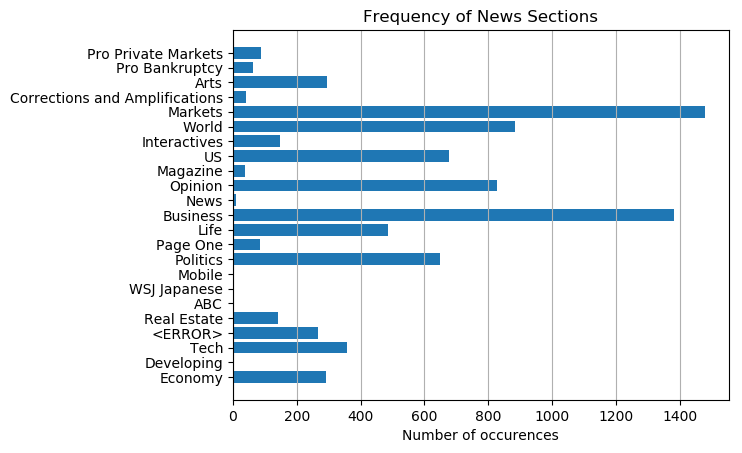

In [32]:
# Checking how many different sections exist and how often they are used
section_counter = Counter()
for section in sections:
    section_counter[section] += 1

plt.barh(np.arange(len(section_counter)), list(section_counter.values()))
plt.yticks(np.arange(len(section_counter)), list(section_counter.keys()))
plt.title("Frequency of News Sections")
plt.xlabel("Number of occurences")
plt.grid(axis="x")
plt.show()

In [33]:
# Filter out sections that rarely occure

MINIMUM_OCCURENCES = 100

cleaned_articles = []
cleaned_sections = []
for a, s in list(zip(articles, sections)):
    if (section_counter[s] >= MINIMUM_OCCURENCES) and (s != "<ERROR>"):
        cleaned_articles.append(a)
        cleaned_sections.append(s)
               
print("Deleted {} articles. There are still {} articles left".format(len(articles) - len(cleaned_articles), len(cleaned_articles)))

Deleted 603 articles. There are still 7623 articles left


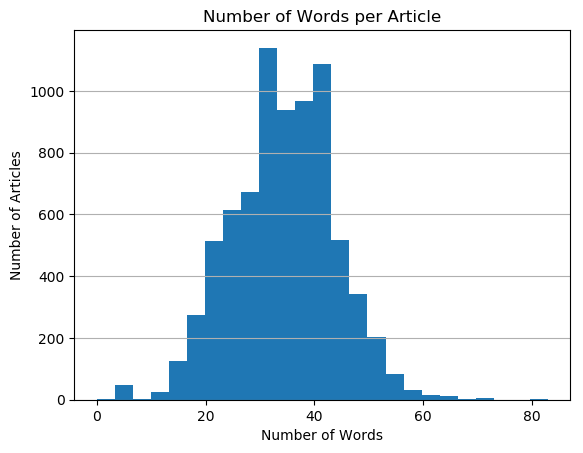

99.6% of the article summaries consist of less or equal 60 words.


In [34]:
# Plot number of words per article

plt.hist([len(a.split()) for a in cleaned_articles],25)
plt.title("Number of Words per Article")
plt.xlabel("Number of Words")
plt.ylabel("Number of Articles")
plt.grid(axis="y")
plt.show()

MAX_LEN = 60
less_or_equal_max_len = 0
for a in cleaned_articles:
    if len(a.split()) <= MAX_LEN:
        less_or_equal_max_len += 1
print("{0:.1f}% of the article summaries consist of less "
      "or equal {1} words.".format(100 * less_or_equal_max_len / len(cleaned_articles), MAX_LEN))

It can be seen that most of the article summaries have not more than 60 words.

In [35]:
# Dictionaries for translating sections into index and back

label_to_index = {}
for s in cleaned_sections:
    if s not in label_to_index:
        label_to_index[s] = len(label_to_index)

index_to_label = dict((i,l) for l, i in label_to_index.items())

# List with all available sections that occure in cleaned dataset
labels = [label_to_index[s] for s in cleaned_sections]

In [36]:
# Maximum number of unique words that should be considered
MAX_NUM_WORDS = 20000

# Number of words per article that are used. If an article has less words,
# it is padded, if an article consists of more words, it is truncated
SEQUENCE_LENGTH = MAX_LEN

# Tokenize words
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(cleaned_articles)

# Transform articles into sequences of tokens
sequences = tokenizer.texts_to_sequences(cleaned_articles)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Padd or truncate articles of length != SEQUENCE_LENGTH
tokenized_articles = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH, padding='pre', truncating='post')

# Tokenize labels (sections)
labels = to_categorical(labels)
print('Shape of data tensor:', tokenized_articles.shape)
print('Shape of label tensor:', labels.shape)

Found 22334 unique tokens.
Shape of data tensor: (7623, 60)
Shape of label tensor: (7623, 12)


In [37]:
# Load GloVe word vectors

embeddings_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s GloVe word vectors.' % len(embeddings_index))

Found 400000 GloVe word vectors.


In [38]:
# Prepare embedding matrix

embedding_dim = embeddings_index["sunday"].shape[0]

print('Preparing embedding matrix.')

num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


In [39]:
# Neural Network Model
models = []
models.append(model_1(SEQUENCE_LENGTH, embedding_layer, len(label_to_index)))
models.append(model_2(SEQUENCE_LENGTH, embedding_layer, len(label_to_index)))
models.append(model_3(SEQUENCE_LENGTH, embedding_layer, len(label_to_index)))

for n, model in enumerate(models):
    print("Model #{}:".format(n))
    model.summary()

Model #0:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 100)           2000100   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 60, 100)           10100     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               102912    
_________________________________________________________________
dense_12 (Dense)             (None, 12)                6156      
Total params: 2,280,068
Trainable params: 279,968
Non-trainable params: 2,000,100
__________________________________________________

In [40]:
history = []
for n, model in enumerate(models):
    print("\nTraining model {}:".format(n))
    print("----------------------")
    history.append(model.fit(tokenized_articles, labels,
          validation_split=0.25,
          shuffle=True,
          batch_size=1024,
          epochs=50,
          verbose=2))


Training model 0:
----------------------
Train on 5717 samples, validate on 1906 samples
Epoch 1/50
 - 25s - loss: 2.3016 - acc: 0.1779 - val_loss: 2.1655 - val_acc: 0.1941
Epoch 2/50
 - 2s - loss: 2.1690 - acc: 0.2008 - val_loss: 2.0822 - val_acc: 0.3353
Epoch 3/50
 - 2s - loss: 2.0233 - acc: 0.3131 - val_loss: 2.0250 - val_acc: 0.2718
Epoch 4/50
 - 3s - loss: 1.8609 - acc: 0.3488 - val_loss: 2.0845 - val_acc: 0.2581
Epoch 5/50
 - 2s - loss: 1.8112 - acc: 0.3607 - val_loss: 1.5905 - val_acc: 0.3940
Epoch 6/50


KeyboardInterrupt: 

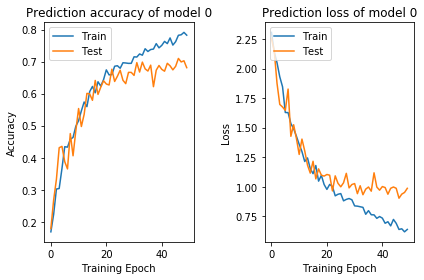

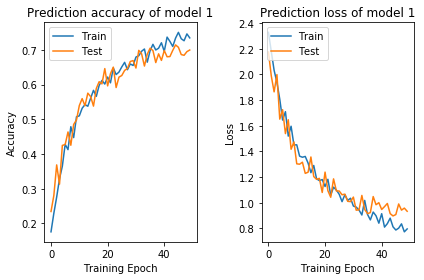

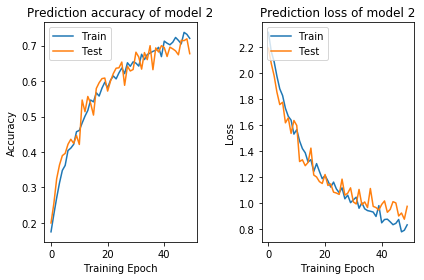

In [19]:
# Plot training and validation accuracy values

for n, h in enumerate(history):
    plot_training_history(h, "model {}".format(n))

In [20]:
def predict_news_section(article, model):
    """Predicts the belonging section for a given news article.
    
    Ags:
        article (str): Unprocessed text of a news article.
        
    Returns:
        section (str):        The name of the predicted news section.
        prob (numpy.ndarray): Predicted probability for each section.
        
    """
    seq = tokenizer.texts_to_sequences([article])
    padd_seq = pad_sequences(seq, maxlen=SEQUENCE_LENGTH, padding='pre', truncating='pre')
    prob = model.predict(padd_seq).flatten()
    return index_to_label[np.argmax(prob)], prob 

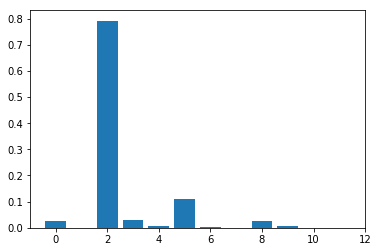

News section:  US
Predicted news section:  US


In [29]:
# Predict the section for a randomly chosen article from the dataset

N = np.random.randint(0, len(cleaned_sections))

predicted_section, probability = predict_news_section(cleaned_articles[N], models[2])
plt.bar(np.arange(len(probability)), probability)
plt.show()
print("News section: ", cleaned_sections[N])
print("Predicted news section: ", predicted_section)